In [1]:
import numpy as np
import pandas as pd
import os
import re
import astropy.units as u
import sys
import multiprocessing as mp
import tqdm

import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='none')
rc('xtick', labelsize=50)
rc('ytick', labelsize=50)
mpl.rcParams['axes.linewidth'] = 2

import vplanet_inference as vpi
sys.path.append(os.path.realpath("../src"))

In [2]:
inpath = os.path.join(vpi.INFILE_DIR, "stellar_eqtide/ctl")

inparams = {
            "primary.dMass": u.Msun, 
            "secondary.dMass": u.Msun, 
            "primary.dRotPeriod": u.day, 
            "secondary.dRotPeriod": u.day, 
            "primary.dTidalTau": u.dex(u.s), 
            "secondary.dTidalTau": u.dex(u.s), 
            "secondary.dEcc": u.dimensionless_unscaled, 
            "secondary.dOrbPeriod": u.day,
            "vpl.dStopTime": u.Gyr
}

outparams = {
             "final.primary.RotPer": u.day, 
             "final.secondary.Eccentricity": u.dimensionless_unscaled,
             "final.secondary.OrbPeriod": u.day,
             "final.secondary.RotPer": u.day
}

ctl = vpi.VplanetModel(inparams, inpath=inpath, outparams=outparams, 
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)

def run_models(vpm, theta_var_array, ncore=4):
    with mp.Pool(ncore) as p:
        outputs = []
        for result in tqdm.tqdm(p.imap(func=vpm.run_model, iterable=theta_var_array), total=len(theta_var_array)):
            outputs.append(result)
        outputs = np.array(outputs)
    return outputs

def plot_evolution_panel(sims1, sims2, sims3, qplot, ls=50, lw=1.5, 
                         savename="evol_plot.png",
                         cb_label=r'$\log(\tau)$ [dex(s)]', 
                         cmap=mpl.cm.jet):
    
    results = [str(tv) for tv in qplot]
    
    c = np.arange(0, len(sims1))
    norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cmap.set_array([])

    fig, axs = plt.subplots(1, 3, figsize=[40,15], sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.18)

    for ii in range(len(results)):

        axs[0].plot(sims1[ii]['Time'], sims1[ii]['final.secondary.OrbPeriod'] / sims1[ii]['final.primary.RotPer'], lw=lw, c=cmap.to_rgba(ii))
        axs[1].plot(sims2[ii]['Time'], sims2[ii]['final.secondary.OrbPeriod'] / sims2[ii]['final.primary.RotPer'], lw=lw, c=cmap.to_rgba(ii))
        im = axs[2].plot(sims3[ii]['Time'], sims3[ii]['final.secondary.OrbPeriod'] / sims3[ii]['final.primary.RotPer'], lw=lw, c=cmap.to_rgba(ii))

    plt.minorticks_on()
    cb = fig.colorbar(cmap, ticks=c, ax=axs, orientation='vertical', pad=.02)
    cb.set_label(cb_label, fontsize=ls)
    cb.ax.set_yticklabels(qplot)

    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[2].set_yscale('log')
    plt.xscale('log')
    plt.xlim(9e5, 8e9)
    plt.ylim(5e-1, 2e2)
    
    axs[0].set_title("Porb/Prot (Porb init = 5)", fontsize=ls)
    axs[1].set_title("Porb/Prot (Porb init = 10)", fontsize=ls)
    axs[2].set_title("Porb/Prot (Porb init = 15)", fontsize=ls)
    axs[0].set_xlabel('Time [yr]', fontsize=ls)
    axs[1].set_xlabel('Time [yr]', fontsize=ls)
    axs[2].set_xlabel('Time [yr]', fontsize=ls)
    axs[2].set_yscale('log')
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[2].minorticks_on()
    # plt.savefig(savename, bbox_inches='tight', transparent=True)
    plt.show()

    return fig

In [10]:
tvals = np.round(np.arange(-4, 2, .4),1)

nsim = len(tvals)
mass1 = np.ones(nsim)
mass2 = np.ones(nsim)
prot1 = 0.5 * np.ones(nsim)
prot2 = 0.5 * np.ones(nsim)
ecc = 0.2 * np.ones(nsim)
ages = 8 * np.ones(nsim)

porb1 = 5 * np.ones(nsim)
porb2 = 10 * np.ones(nsim)
porb3 = 15 * np.ones(nsim)

theta_tau1 = np.array([mass1, mass2, prot1, prot2, tvals, tvals, ecc, porb1, ages]).T
theta_tau2 = np.array([mass1, mass2, prot1, prot2, tvals, tvals, ecc, porb2, ages]).T
theta_tau3 = np.array([mass1, mass2, prot1, prot2, tvals, tvals, ecc, porb3, ages]).T

In [12]:
ctl_evol1 = run_models(ctl, theta_tau1, ncore=6)
ctl_evol2 = run_models(ctl, theta_tau2, ncore=6)
ctl_evol3 = run_models(ctl, theta_tau3, ncore=6)

100%|██████████| 15/15 [03:47<00:00, 15.15s/it]


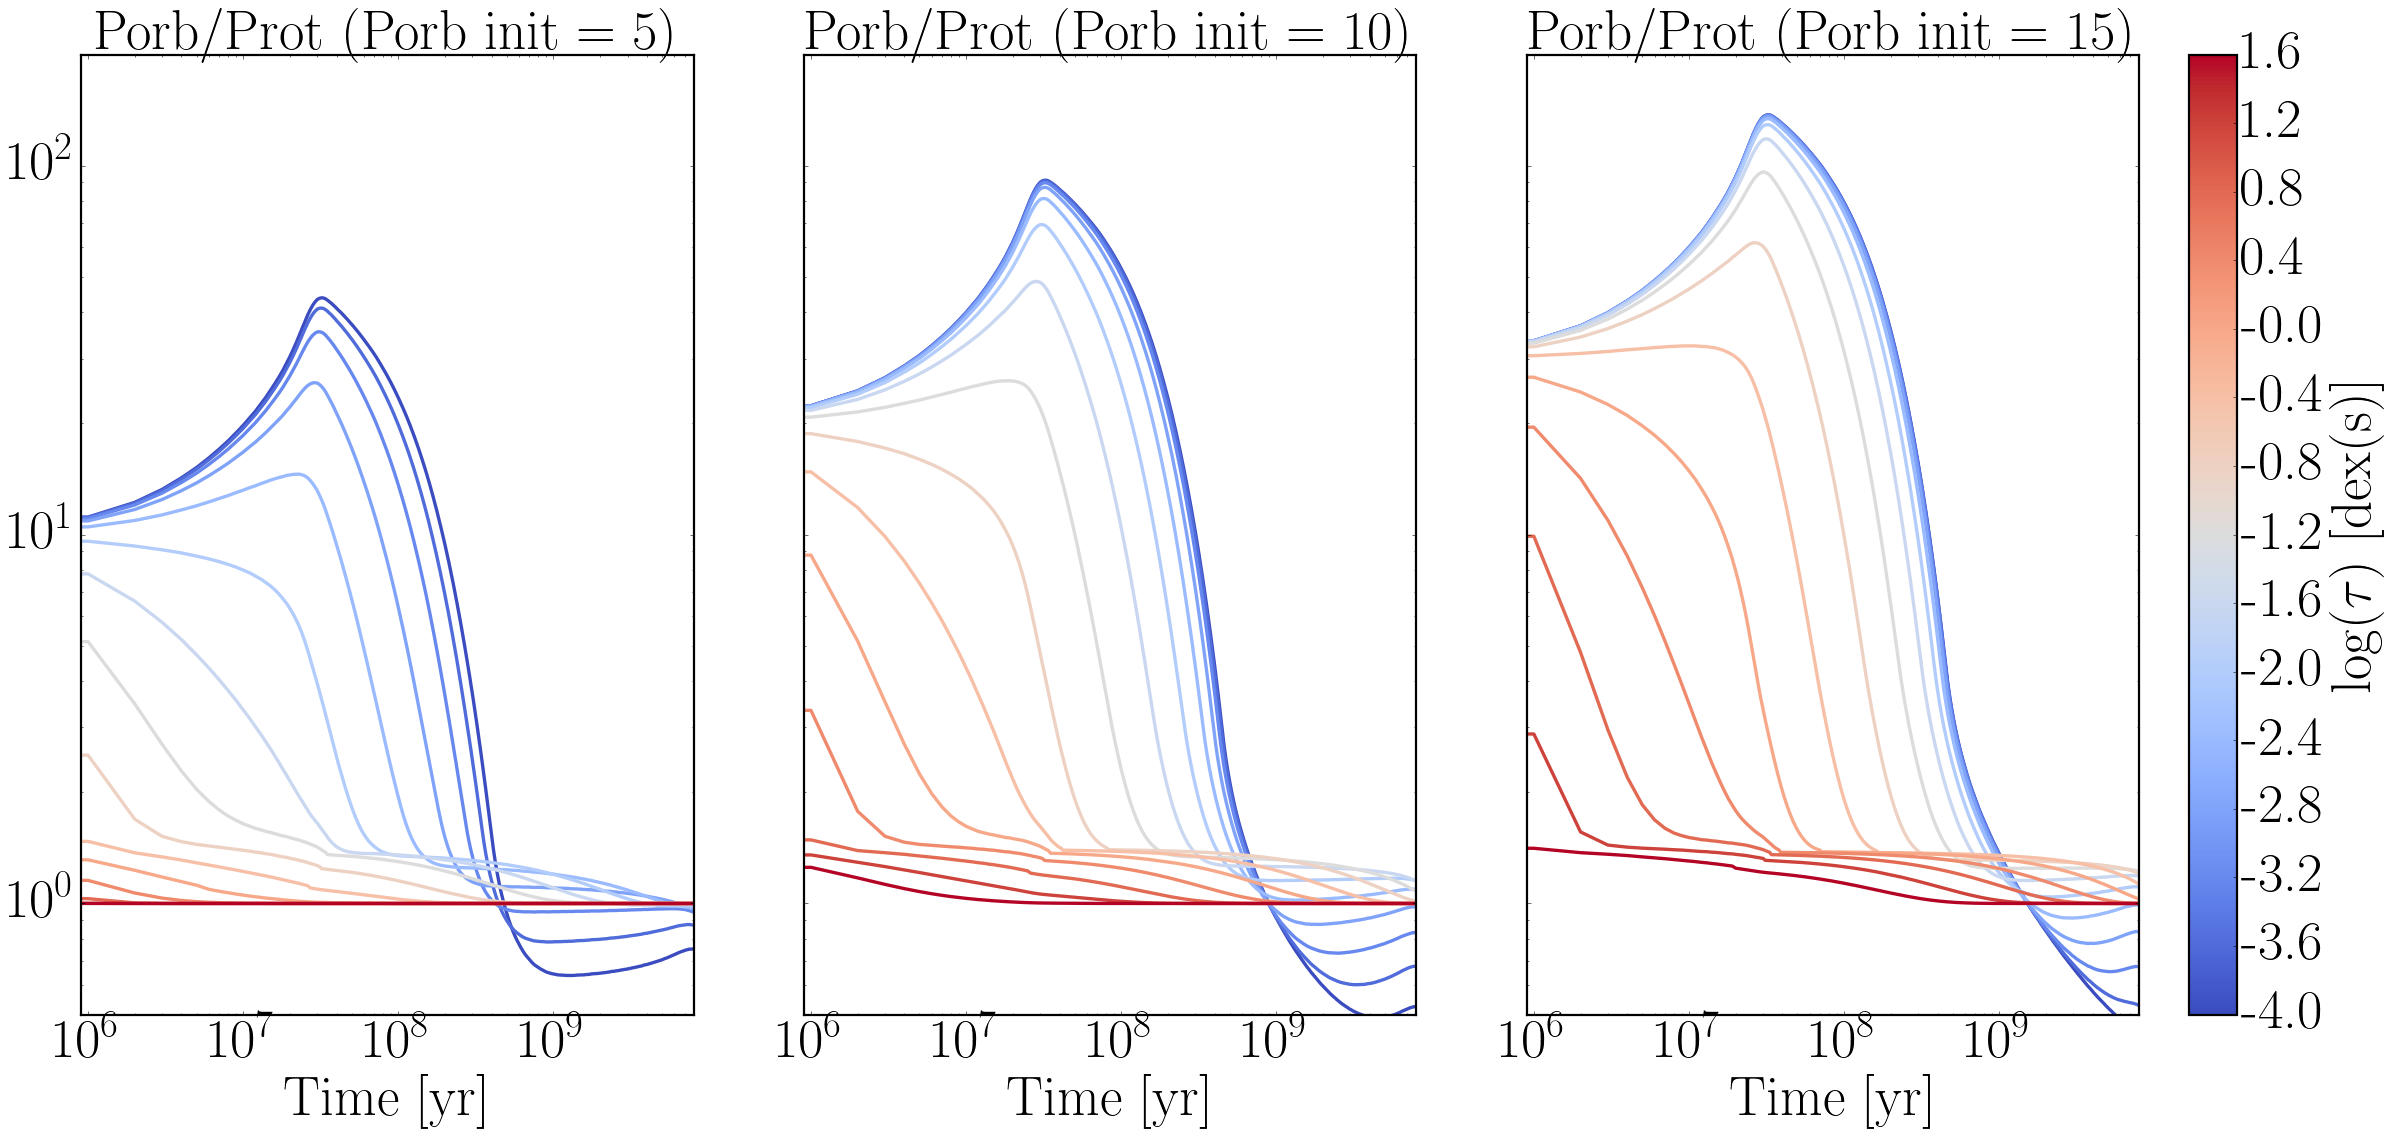

In [28]:
fig = plot_evolution_panel(ctl_evol1, ctl_evol2, ctl_evol3, tvals, cb_label=r'$\log(\tau)$ [dex(s)]', cmap=mpl.cm.coolwarm, lw=3)
fig.savefig("../apj_submission2/eqtide_ctl_ratio.png", bbox_inches='tight')